<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.15

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Import and mount Google Drive.
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# # Unzip the dataset file and store it in a folder called images.
# !unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

In [6]:
label_dict = {'benign' : 0,
              'malignant' : 1}

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Project_BC/cnn/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "valid/*/*")

In [7]:
def img_process(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size=[320,320])
  image = image / 255.0
  return image, label

In [8]:
train_ds = train_list_ds
val_ds = valid_list_ds

# parsing and processing the training images
train_ds = (
    train_ds
    .shuffle(1000)
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

# parsing and processing the validation images
val_ds = (
    val_ds
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

In [9]:
# input layer
input_layer = layers.Input(shape=(320, 320, 3), name='Input')

# convolutional layers
conv0 = layers.Conv2D(16, (5, 5), activation='relu', padding="same",
                      strides=(2, 2), name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv1')(conv0)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv2')(conv1)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv3')(pool1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv4')(conv3)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(conv4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv5')(pool2)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv6')(conv5)
global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(conv6)

# fully connected layers
fc1 = layers.Dense(512, activation='relu', name='FC1')(global_pool)

# output layer
output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 320, 320, 3)]     0         
                                                                 
 Conv0 (Conv2D)              (None, 160, 160, 16)      1216      
                                                                 
 Conv1 (Conv2D)              (None, 160, 160, 32)      4640      
                                                                 
 Conv2 (Conv2D)              (None, 160, 160, 32)      9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 80, 80, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 80, 80, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 80, 80, 64)        36928 

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
checkpoint_filepath = '/content/checkpoint/'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [13]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)

In [14]:
epoch_num=10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch_num,
    callbacks=[checkpoint_callback, lr_callback]
)

Epoch 1/10
19/19 [==============================] - 58s 2s/step - loss: 0.6807 - accuracy: 0.6615 - val_loss: 0.6651 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 2/10
19/19 [==============================] - 7s 343ms/step - loss: 0.6533 - accuracy: 0.6615 - val_loss: 0.6552 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 3/10
19/19 [==============================] - 6s 341ms/step - loss: 0.6474 - accuracy: 0.6615 - val_loss: 0.6500 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 4/10
19/19 [==============================] - 7s 352ms/step - loss: 0.6444 - accuracy: 0.6615 - val_loss: 0.6476 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 5/10
19/19 [==============================] - 7s 347ms/step - loss: 0.6425 - accuracy: 0.6615 - val_loss: 0.6447 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 6/10
19/19 [==============================] - 7s 350ms/step - loss: 0.6406 - accuracy: 0.6615 - val_loss: 0.6425 - val_accuracy: 0.6637 - lr: 5.0000e-05
Epoch 7/10
19/19 [==============================

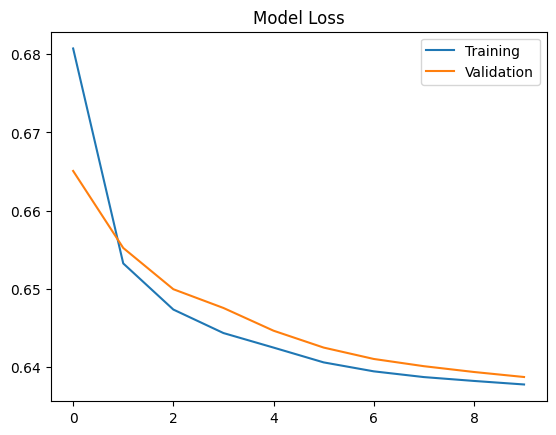

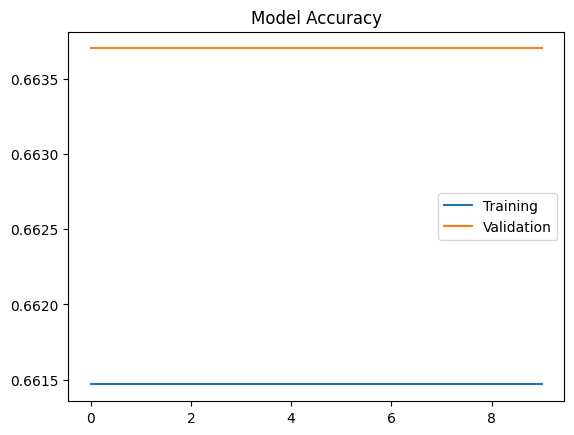

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()